# Exercise Session 5: Deep Learning
---
Before starting the session do the following things:
* Got to File > Save a Copy in Drive
* Open the copy you made
* Go to Runtime > Change Runtime Type; under hardware acceleration select GPU in the dropdown menu

---

Today you'll be introduced to the wonderful world of Deep Learning. We'll show you a practical example using the `pytorch` framework.

Since there's too much content to digest and apply by yourself in a two hours session, this exercice session will take a rather unusual turn: we'll provide the code and guide you through it step-by-step explaining the details in order for you to achieve a good understanding. Finally you'll be able to modify some parameters and tune in some dials to see their effect for yourself.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from IPython.display import clear_output

import time
from collections import OrderedDict, namedtuple
from itertools import product
!pip install pytorch-ignite
!pip install umap-learn
from umap import UMAP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 990.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=0fad20abc7676e2931dbf2d75818b2914e91539de7f8d715ce8a26022ef5a0c6
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=86c32c842d5a06982c3268ad6bfc1630b0f1c2689eef6018e7a646189fe06636
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


## 0. The Pytorch framework

In the past exercices sessions, you've already gotten familiar with several Python frameworks (numpy, scikit-learn,...). These provide a set of functions and classes that are useful when solving specific type of problems. Pytorch is just another framework that is useful when training deep neural networks (other alternative frameworks exist for deep learning, e.g. Tensorflow and Keras).

Using the Pytorch framework requires you to learn its language, but will bring you huge benefits. For example, Pytorch enables you to:
- run your programs on a GPU rather than a CPU (much faster for neural networks)
- use an automatic differentiation tool (it computes gradients automatically for you)

## 1. Dataset

Before even training a model, we first need to load the data. Datasets are often large and training takes long, making cross-validation an often disregarded aspect of model-validation and wrongfully so. Due to time constraints, you'll only be using the 3 following data-folds:

- *Training set*: The model's parameters will be computed based on these examples
- *Validation set*: The model's generalization during training will be observed using this data. It can also be used to select the best model across different epochs (or training-iterations)
- *Test set*: This dataset is only used at the **very end** to compute the model's performance

The dataset in question is Fashion-mnist. It is composed of 70k (54k/6k/10k for train/val/test sets) 28x28 grayscale images. Each image can be classified into one of 10 clothing categories.
(You can also run this notebopk by using the Cifar10 dataset which has 60k 32x32 RGB images (45k/5k/10k for train/val/test).)

In [ ]:
from torch.utils.data import Subset

# Torchvision contains a link to download the FashionMNIST dataset. Let's first
# store the training and test sets.

dataset_name = "FashionMNIST"
dataset = torchvision.datasets.FashionMNIST
n_input_channels = 1

# Uncomment the following to use Cifar10 instead of fashion-mnist
# dataset_name = "Cifar10"
# dataset = torchvision.datasets.CIFAR10
# n_input_channels = 3

train_data = dataset(
    root = f'./data/{dataset_name}',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()  # Move data to a pytorch tensor
    ])
)
# We now divide the training data in training set and validation set.
n_train = len(train_data)
indices = list(range(n_train))
split = int(n_train - (n_train * 0.1))  # Keep 10% for validation
train_set = Subset(train_data, indices[:split])
val_set = Subset(train_data, indices[split:])

test_set = dataset(
    root = f'./data/{dataset_name}',
    train = False,
    download = False,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)
try:
  classes = dataset.classes
except:
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(f"\n {dataset_name} contains the following 10 classes:\n{', '.join(classes)}")

def get_data_loaders(batch_size):
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
  return train_loader, val_loader, test_loader


100%|██████████| 26421880/26421880 [00:01<00:00, 16066811.84it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270115.21it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5025624.49it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21921093.39it/s]


Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


 FashionMNIST contains the following 10 classes:
T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot


## 2. Neural Networks

### 2.0 The pytorch way

#### 2.0.0 Convolutional Layer
As a quick reminder this is what a convolution looks like (full gif [here](https://miro.medium.com/max/395/1*1okwhewf5KCtIPaFib4XaA.gif)):

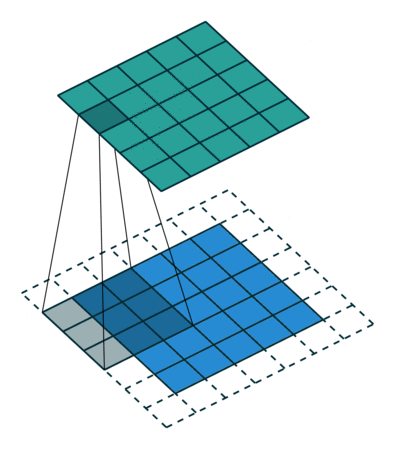

Every blue pixel (below) is multiplied by the grey kernel (transparent), the result of which is summed in order to create 1 green pixel (above). We repeat this operation for every blue pixel by 'sliding' the kernel on the image (see gif).
Things become a tad more complex when we look at a complete convolutional layer:

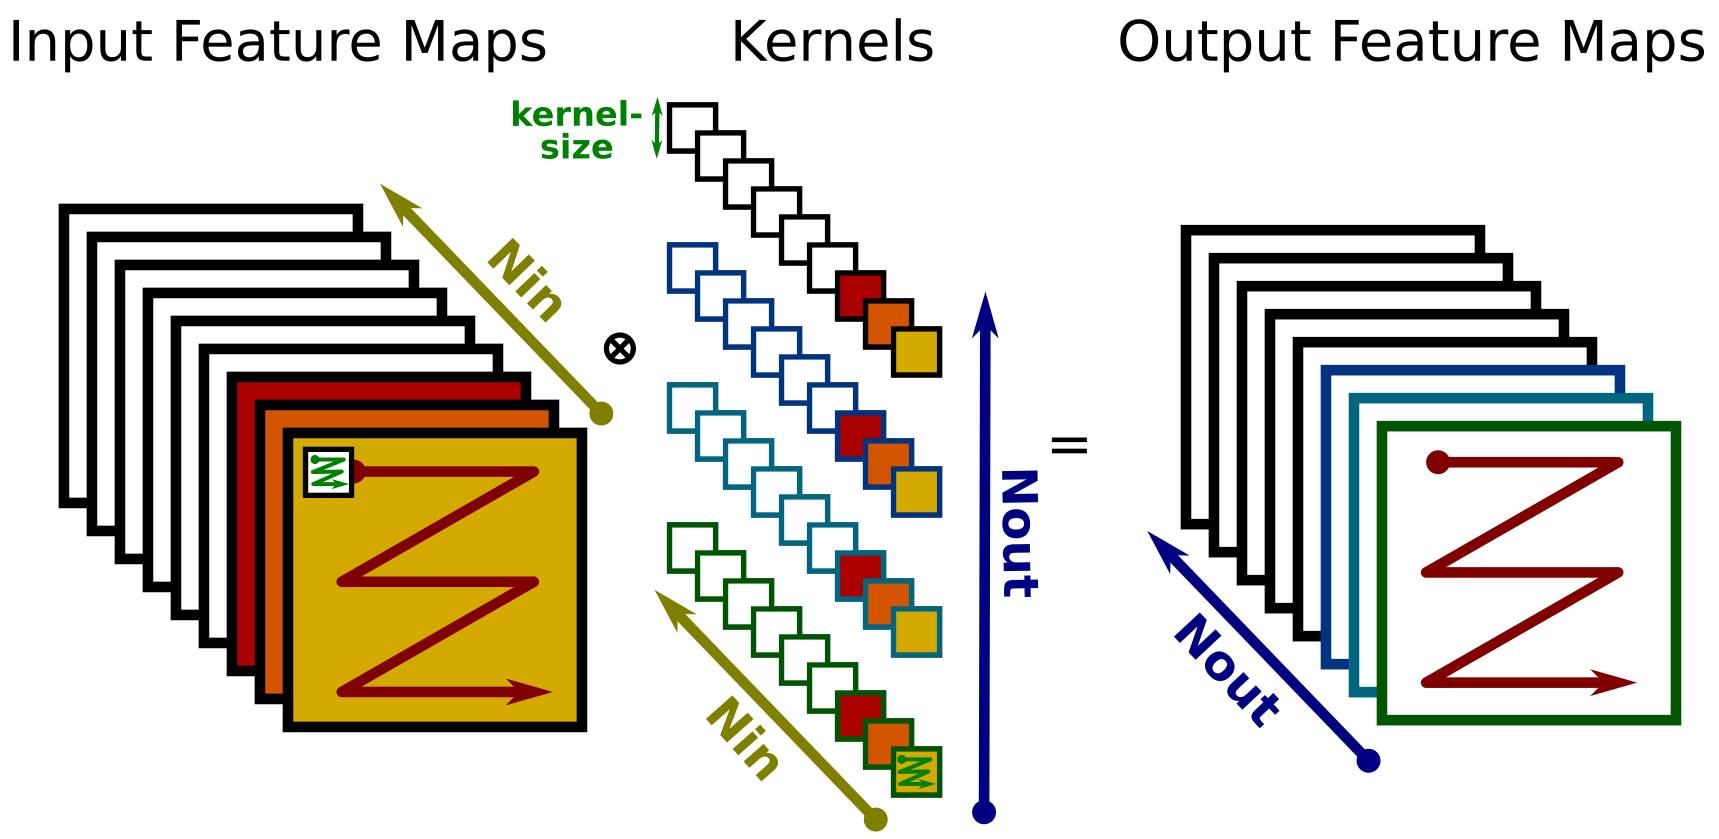

Now we don't only perform 1 convolution, but repeat this operation Nin $\times$ Nout times. Every output feature map (= output channel) is the result of the sum of the convolution of every individual input feature map with a different kernel. In other words to obtain 1 output feature map you must:
* Convolve every input feature map individually with a different kernel (different meaning the values contained will be different but the size stays the same)
* Do a pixel-wise sum of the Nin results

To obtain the final output feature maps, you simply repeat this operation Nout times! You can quite easily see that this layer is very computationally intensive, which is why we'll use GPU's for this session. (Bonus Question: do you know how many Floating Point operations are performed inside such a convolutional layer?)

A quick visualization on what a convolutional layer does to refresh your memory can also be found [in the first part of this blogpost](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1).  



#### 2.0.1 Tensors
In pytorch all data is encoded as a `Tensor`. An object that can be closely assimilated to a `numpy` array. Tensors can be used for arithmetic operations like multiplications, additions etc.

Since we'll be working with Neural Networks, the tensors we'll be using will have one of the 2 following shapes when handling input/output tensors:
 - [B, N]: When working with linear (=fully connected) layers
 - [B, N, H, W]: When working with convolutional (=conv.) layers

Where:
 - B = batch-size
 - N = #channels (e.g for images, channels are typically RGB)(also called feature maps inbetween conv. layers)
 - H = height of the feature map
 - W = width of the feature map

Weight tensors will have the following shapes:
 - [Nout, Nin]: Linear layers
 - [Nout, Nin, Kx, Ky]: Conv. layers

Where:
 - Nout = #output channels
 - Nin  = #input channels
 - Kx = kernel size in horizontal dimension
 - Ky = kernel size in vertical dimension (often equal to Kx)

In the following example try to predict the shape of `linear_out` and `conv_out` **before** executing the cell below.
Try changing the values and see how the shape changes.

In [ ]:
with torch.no_grad():
  linear_in = torch.rand([33, 64])
  linear_weight = torch.rand([128, 64])
  linear_out = F.linear(linear_in, linear_weight)
  print(f"The shape of linear_out is {linear_out.shape}")

  conv_in = torch.rand([16, 8, 4, 4])
  conv_weight = torch.rand([4, 8, 2, 2])
  conv_out = F.conv2d(conv_in, conv_weight, padding=0)  # What does padding do according to you?
  print(f"The shape of conv_out is {conv_out.shape}")

The shape of linear_out is torch.Size([33, 128])
The shape of conv_out is torch.Size([16, 4, 3, 3])


#### 2.0.2 Layers
A layer in pytorch is defined as being a `Module` object, meaning it has 2 important methods:
 - `__init__()` (or constructor): The layers (and their associated weights) are initialized here
 - `forward()`: This function will be called when data will be passed through the network

What follows next are 2 toy examples:
 - One on how `forward()` works
 - And a more concrete example that reimplements a (somewhat) simplified forward pass of the nn.Conv2d layer in pytorch

In [ ]:
class SimpleAddition(nn.Module):
  def __init__(self, param):
    """
        param: A value that will be added to every
          tensor that will come through
    """
    super().__init__() # mandatory call to the super constructor (constructor of class nn.Module)
    print("The module has been initialized!")
    self.param = param

  def forward(self, nx):
    """
        nx: This 'layer's input' as a tensor
        returns the tensor with self.param added
    """
    print("Forward has been called!")
    return nx+self.param

xx = torch.rand(2,4)
print(f"xx before: \n{xx}")

my_addition = SimpleAddition(param=5) # construction of a SimpleAddition object -> calls __init__()

xx = my_addition(xx) # implicit call to forward() -> equal to instruction: xx = my_addition.forward(xx)

print(f"xx after: \n{xx}")

xx before: 
tensor([[0.0780, 0.8056, 0.1630, 0.7448],
        [0.0112, 0.4201, 0.7882, 0.9614]])
The module has been initialized!
Forward has been called!
xx after: 
tensor([[5.0780, 5.8056, 5.1630, 5.7448],
        [5.0112, 5.4201, 5.7882, 5.9614]])


In [ ]:
class MyConv2d(nn.Module):
  def __init__(self, nin, nout, ksize):
    """
        nin: #input channels
        nout: #output channels
        ksize: kernel size (same for both dimensions)
    """
    super().__init__()
    self.padding = ksize//2  # This is what you'll want most of the time
                             #  to avoid dimension reduction

    # Neural network initialization is a complicated topic and we won't go too
    #   deep into this today, just know that using a Normally ditributed
    #   Kaiming He init is good starting point
    #   (https://arxiv.org/pdf/1502.01852.pdf)
    #   (If you want more sources, don't hesitate to send us an e-mail)
    with torch.no_grad():
      self.weights = torch.zeros(nout, nin, ksize, ksize
        ).normal_(0, np.sqrt(2/nin))

  def forward(self, nx):
    return F.conv2d(nx, self.weights, padding=self.padding)

my_conv = MyConv2d(nin=8, nout=4, ksize=3)
xx = torch.rand(12, 8, 5, 5)
xx = my_conv(xx)
print(xx.shape)

torch.Size([12, 4, 5, 5])


#### 2.0.3 Gradients

In order to be able to train a neural network you'll need to compute the gradients throughout the network. We unfortunately don't have the time to explain to you how this all works inside the `pytorch` framework. Just remember for now that it is computed automatically.

### 2.1 Some typical structures
#### 2.1.1 The basic convolutional block

*Activation*

Convolutional Neural Networks (*CNN*) need to use a non-linear activation function in order to be able to approximate non-linear functions. One that has been shown to work well is `ReLU`. It sets negative values to zero and is linear for the positive ones.



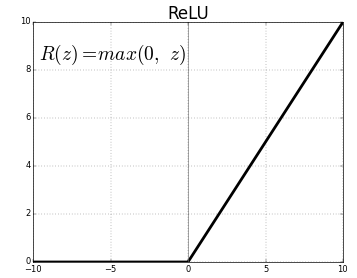




*Normalization*

CNN also use some tricks to help training convergence. One of those is `Batch-Normalization` which helps by recentering and scaling the data inbetween layers:
$$ BN(\mathbf x) = \gamma \frac{\mathbf x - \mu_{\mathbf x}}{\sqrt{\sigma_{\mathbf x}^2+\epsilon}}+\beta $$
Thus it learns 4 parameters per channel ($\epsilon$ is only there for numerical stability):
 - $\mu_{\mathbf x}$ = The mean value of the samples
 - $\sigma_{\mathbf x}$ = The mean variance of the samples
 - $\gamma$ = A scaling factor
 - $\beta$ = A bias factor

*CBA*

Putting this together we get a *sequence* of 3 layers you'll often encounter in CNNs: Conv-BN-Act

*(The number of channels is also refered to as the 'width' of the network, which makes for clearer variable names. Thus nin->in_width, nout->out_width etc.)*

In [ ]:
class CBA(nn.Module):
  def __init__(self, in_width, out_width, ksize=5):
    super().__init__()
    padding = ksize // 2
    self.cba = nn.Sequential(
      nn.Conv2d(
          in_channels=in_width, out_channels=out_width,
          kernel_size=ksize, padding=padding
      ),
      nn.BatchNorm2d(out_width),
      nn.ReLU()
    )
  def forward(self, nx):
    return self.cba(nx)


#### 2.1.2 Subsampling via Max-Pooling

You'll often want to subsample an image in a CNN. To achieve this step, a `Max-Pooling` layer is often used. This layer acts as a filter, it selects the maximal value inside a certain kernel size and **lets only that one pass**. Thus reducing the image/feature map size!
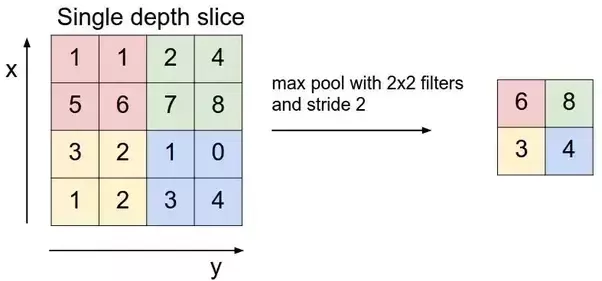



In [ ]:
xx = torch.rand(1,1,4,4)
print("Before:")
print(xx[0,0,:,:])
xx = F.max_pool2d(xx, kernel_size=2, stride=2)
print("After:")
print(xx[0,0,:,:])

Before:
tensor([[0.4774, 0.7734, 0.5222, 0.0241],
        [0.7847, 0.2842, 0.1030, 0.8383],
        [0.1655, 0.7552, 0.4411, 0.3455],
        [0.3035, 0.6647, 0.4561, 0.1913]])
After:
tensor([[0.7847, 0.8383],
        [0.7552, 0.4561]])


### 2.2 Composing the full network

We can now finally put all of this together and create our *first* network!

A typical CNN will start with the full resolution image (in our case 28x28). But step by step this image will be down-sampled, all the while the number of channels will increase. This will lead the network to **extract features** and encode them each on a different channel in the later (=deeper) layers.

The final linear layer's purpose is to associate those *features* with their correct *classification*.


In [ ]:
class Network(nn.Module):
  def __init__(self, n_classes=10, width = 16, input_size=1):
    super().__init__()

    self.convs = nn.Sequential(
      CBA(input_size, width),
      nn.MaxPool2d(kernel_size=2,stride=2),  # 14x14
      CBA(width, width*2),
      nn.MaxPool2d(kernel_size=2,stride=2),  #  7x7
      CBA(width*2, width*4),
      nn.MaxPool2d(kernel_size=2,stride=2),  #  3x3
      CBA(width*4, width*8, ksize=3),
    )
    self.top = nn.Linear(8*width, n_classes)

  def forward(self, nx, no_top=False):
    nx = self.convs(nx)
    nx = F.adaptive_avg_pool2d(nx, (1,1)).squeeze(-1).squeeze(-1)
    if no_top:
      return nx
    return self.top(nx)

## 3. The Training Loop

You should now have an operational network and only one step remains: the training!

Training a NN is done iteratively: the dataset is split in batches. Everytime a *batch* goes through the network we'll refer to it as an **iteration**, and everytime the *dataset* has completely gone through (over multiple batches thus iterations), an **epoch**.

During the iteration a batch will go through the network to make predictions (=**forward pass**), and gradients will be computed based on the prediction errors (=**backward pass**). Those gradients are computed *numerically* by Pytorch. Finally the **weights** are updated by the **optimizer** (in our case Stochastic Gradient Descent) in order to reduce the final loss. This process is repeated untill convergence (or a maximal number of epochs) has been reached.

In [ ]:
"""
    Don't worry about this code
"""
class MetricsList():
  def __init__(self, metrics, names):
    self.metrics = metrics
    self.names = names
    self.df = pd.DataFrame(columns=names)

  def update(self, logits, labels):
    """
        Updates all the metrics
        - logits: output of the network
        - labels: ground truth
    """
    for metric in self.metrics:
      metric.update((logits, labels))

  def reset(self):
    for metric in self.metrics:
      metric.reset()

  def clear(self):
    self.df = self.df.iloc[0:0]  # Clear Dataframe

  def compute(self, mode):
    data = []
    for metric in self.metrics:
      data.append( metric.compute() )
    self.df.loc[mode] = data

  def __str__(self):
    return str(self.df)

In [ ]:
import time
from ignite.metrics import Loss as MLoss
from ignite.metrics import Accuracy as MAccuracy

# Object where the data should be moved to:
#   either the CPU memory (aka RAM + cache)
#   or GPU memory
device = torch.device('cuda') # Note: cuda is the name of the technology inside NVIDIA graphic cards
network = Network(input_size=n_input_channels).to(device) # Transfer Network on graphic card.

# Set the training parameters
epochs = 15
lr = 0.1
optimizer = optim.SGD(network.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
batch_size = 128

# Load the data
train_loader, val_loader, test_loader = get_data_loaders(batch_size)

# Metrics in order to check how the training's going
metrics = MetricsList(
    metrics=[MLoss(F.cross_entropy), MAccuracy()],
    names=["Loss", "Accuracy"]
)

# Complete Training Loop
for epoch in range(epochs):
    print(f"--- Starting epoch {epoch}")
    start = time.time()

    # Train the model
    print("Training...")
    metrics.reset()

    network.train() # Set the network in training mode => weights become trainable aka modifiable
    for batch in train_loader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()  # (Re)Set all the gradients to zero

      preds = network(images)  # Infer a batch through the network

      loss = F.cross_entropy(preds, labels)  # Compute the loss
      loss.backward()  # Compute the backward pass based on the gradients and activations
      optimizer.step()  # Update the weights

      metrics.update(preds, labels)
    metrics.compute("Train")

    # Validate the model
    print("Validating...")
    with torch.no_grad():
      metrics.reset()

      network.eval() # Freeze the network >< training mode
      for batch in val_loader:
          images, labels = batch
          images, labels = images.to(device), labels.to(device)

          preds = network(images)
          metrics.update(preds, labels)
      metrics.compute("Validation")
    print(metrics)
    metrics.clear()

    end = time.time()

    # Print logging
    print(f"\n-Ending epoch {epoch}: elapsed time {end - start}\n")


# Test the model on completely unseen data
print("Testing...")
with torch.no_grad():
  metrics.reset()
  network.eval()
  for batch in test_loader:
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      preds = network(images)
      metrics.update(preds, labels)
  metrics.compute("Test")
print(metrics)
metrics.clear()

--- Starting epoch 0
Training...
Validating...
                Loss  Accuracy
Train       0.444672  0.837833
Validation  0.336691  0.879833

-Ending epoch 0: elapsed time 13.9865403175354

--- Starting epoch 1
Training...
Validating...
                Loss  Accuracy
Train       0.285883  0.896352
Validation  0.279696  0.898333

-Ending epoch 1: elapsed time 10.466168403625488

--- Starting epoch 2
Training...
Validating...
                Loss  Accuracy
Train       0.243741  0.911074
Validation  0.306532  0.887167

-Ending epoch 2: elapsed time 10.14157772064209

--- Starting epoch 3
Training...
Validating...
                Loss  Accuracy
Train       0.224645   0.91737
Validation  0.333604   0.87700

-Ending epoch 3: elapsed time 9.799497365951538

--- Starting epoch 4
Training...
Validating...
                Loss  Accuracy
Train       0.205481   0.92437
Validation  0.342501   0.88050

-Ending epoch 4: elapsed time 10.005438804626465

--- Starting epoch 5
Training...
Validating...
  

## 4. GradCam

We will now try to visualize **why** the Neural Network took a certain decision. This process is called `GradCam` and uses the gradients and forward activations to determine which part of the image was used for the final classification.

*If you'd ever want to go deeper into the rabbit hole, here is the paper: https://arxiv.org/pdf/1610.02391.pdf*

Execute the cells below and change the image you want to analyze. Do you conclude that your network's answers are based on sensible features?

In [ ]:
"""
    Don't worry about this code, you don't need to understand it
"""
class GradCam:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.hooks = []
        self.fmap_pool = dict()
        self.grad_pool = dict()

        def forward_hook(module, input, output):
            self.fmap_pool[module] = output.detach().cpu()
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[module] = grad_out[0].detach().cpu()

        for layer in layers:
            self.hooks.append(layer.register_forward_hook(forward_hook))
            self.hooks.append(layer.register_backward_hook(backward_hook))

    def close(self):
        for hook in self.hooks:
            hook.remove()

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.close()

    def __call__(self, *args, **kwargs):
        self.model.zero_grad()
        return self.model(*args, **kwargs)

    def get(self, layer):
        assert layer in self.layers, f'{layer} not in {self.layers}'
        fmap_b = self.fmap_pool[layer] # [B, N, H, W]
        grad_b = self.grad_pool[layer] # [B, N, H, W]

        grad_b = F.adaptive_avg_pool2d(grad_b, (1, 1)) # [B, N, 1, 1]
        gcam_b = (fmap_b * grad_b).sum(dim=1, keepdim=True) # [B, 1, H, W]
        gcam_b = F.relu(gcam_b)

        return gcam_b

correct label = Sneaker
maxval,ind = 17.481191635131836, 7 => Sneaker


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


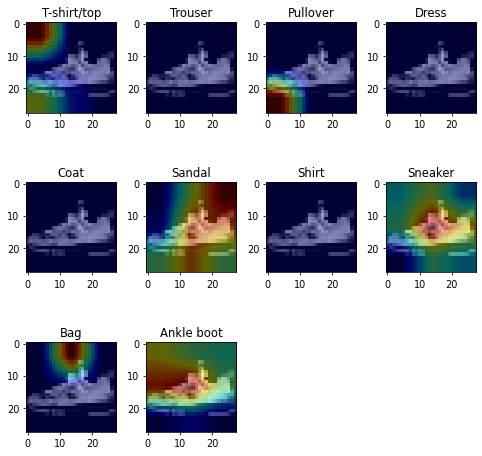

In [ ]:
# Select image to analyze
k = 160  # TODO: change me at will
batch = test_set[k]
orig_img = batch[0]
t_label = classes[batch[1]]
print(f'correct label = {t_label}')

img = orig_img.clone().detach().requires_grad_(True) # Make Tensor
img = img.unsqueeze(dim=0)  # [1, 28, 28] -> [1, 1, 28, 28]
img = img.to(device)  # move to gpu

img2 =  np.stack((orig_img[0],)*3, axis=-1)

# Initializing & executing gradcam
layerList = [network.convs[i] for i in range(len(network.convs))]
with GradCam(network, layerList) as gcam:
    out_b = gcam(img) # [B, N]
    maxval,ind = torch.max(out_b[0],0)
    print(f'maxval,ind = {maxval}, {ind} => {classes[ind]}')
    fig=plt.figure(figsize=(7,7), dpi=70)

    for i, label in enumerate(classes):
      label = classes[i]
      out_b[:, i].backward(retain_graph=True)

      gcam_b = gcam.get(network.convs[-1]) # [B, 1, H, W]
      gcam_b = F.interpolate(gcam_b, [28, 28], mode='bilinear', align_corners=False) # [B, 1, H, W]

      plt.subplot(len(classes)//4+1,4,i+1)
      plt.imshow(img2,alpha=1)
      plt.imshow(gcam_b[0,0],cmap='jet',alpha=0.4)
      plt.title(f"{label}")

plt.tight_layout()
plt.show()


# 5. Dimensionality Reduction for class separation
## 5.1 Comparing supervized features
We can now try to visualize how well the features are extracted. To this end we will use [UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html). This algorithm can **learn** a low dimensional representation of high-dimensional data. In our case we will compare 3 different approaches:
* Using the input images as is
* Using a randomly initialized CNN
* Using a trained CNN

Try to answer the following questions:
* Do you see clear clusters emerging when looking at the images?
* Does the learned 2d mapping of umap translate to testing data? Why?
* What are your overall conclusions when comparing the 3 results?
* What does this mean for CNNs?

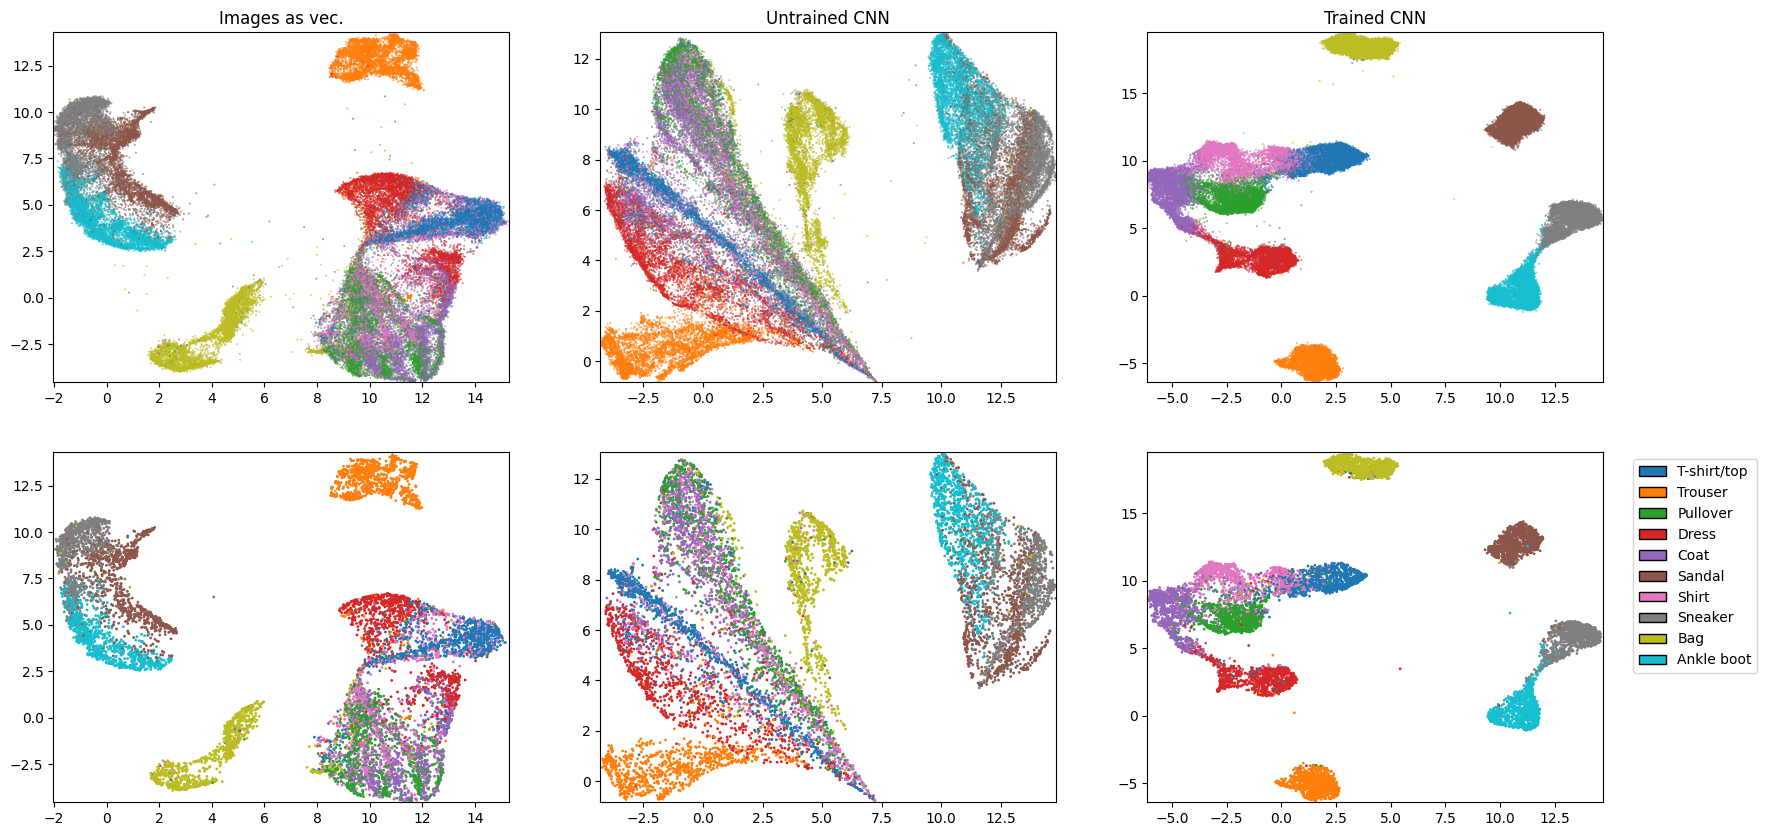

In [ ]:
def get_features(loader, network=None):
  """ If network is None:
        Returns all the images as features (averaged on RGB) e.g. a 28x28 img becomes a vector of size 784
      Else:
        Returns the features of the network of the layer before the final classification for all images
  """
  features = None
  labels = None
  with torch.no_grad():
    if network is not None:
      network.eval()
    for batch in loader:
      images, labels_ = batch
      if network is None:
        features_ = torch.mean(images, dim=1)
      else:
        features_ = network(images.to(device), no_top=True).cpu()
      features_ = features_.reshape((images.size(0), -1))
      if features is None:
        features = features_
        labels = labels_
      else:
        features = torch.cat((features, features_))
        labels = torch.cat((labels, labels_))
  return features, labels

network_rand = Network(input_size=n_input_channels).to(device)
plt.figure(figsize=(20,10))
for i, (name, net) in enumerate(zip(["Images as vec.", "Untrained CNN", "Trained CNN"], [None, network_rand, network])):
  # Collect the data
  train_images, labels_train = get_features(train_loader, net)
  test_images, labels_test = get_features(test_loader, net)
  limit = 30000

  # Learn 2d representation
  fitter = UMAP()
  fitter.fit(train_images[:limit].numpy()) # Limit train images due to memory constraints on google colab
  vecs_train = fitter.transform(train_images.numpy())
  vecs_test = fitter.transform(test_images.numpy())
  del fitter

  # Plot data
  xmin = min(np.min(vecs_train[:,0]), np.min(vecs_test[:,0]))
  xmax = max(np.max(vecs_train[:,0]), np.max(vecs_test[:,0]))
  ymin = min(np.min(vecs_train[:,1]), np.min(vecs_test[:,1]))
  ymax = max(np.max(vecs_train[:,1]), np.max(vecs_test[:,1]))
  colors = np.array(sns.color_palette("tab10"))
  ax = plt.subplot(2,3, i+1)
  ax.set_title(name)
  ax.scatter(vecs_train[:,0], vecs_train[:,1], c=colors[labels_train.numpy()], s=0.1)
  ax.set_xlim([xmin, xmax])
  ax.set_ylim([ymin, ymax])
  ax = plt.subplot(2,3, i+4)
  ax.scatter(vecs_test[:,0], vecs_test[:,1], c=colors[labels_test.numpy()], s=1)
  ax.set_xlim([xmin, xmax])
  ax.set_ylim([ymin, ymax])

# Add legend
legend_elements = [
  Patch(facecolor=c, edgecolor='black', label=l)
  for c,l in zip(colors, classes)
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))



### 5.2 (Bonus) Self-supervised Feature Extraction
As you should've noted earlier, the learned features from the network are discriminative enough, enabling a better 2D representation of the data. But could there be a way to learn similarly intelligent representations without needing class labels? What if we invented a proxy-task on which we could train our CNN. Let's say we rotate the images by {0°, 90°, 180°, 270°} and ask the network to classify them according to their rotation? Would this lead to usefull extracted features? ([source](https://arxiv.org/pdf/1803.07728.pdf))

Run the cell below to train a new network and the one after that to visualize the 2d projection.

* How does it compare to the 3 previous ones? Is it what you expected?

Now go back to the 2nd cell of this notebook and rerun everything on Cifar10 (uncomment the 3 lines of code).
* Do your conclusions stay the same? Why? (Hint: which dataset seems easier when looking at the pictures?)

#### 5.2.1 (Super Bonus) Now it's your turn !

Which algorithm could be used to quantify how well this representation truly is?

In [ ]:
import time
from ignite.metrics import Loss as MLoss
from ignite.metrics import Accuracy as MAccuracy

# Object where the data should be moved to:
#   either the CPU memory (aka RAM + cache)
#   or GPU memory
device = torch.device('cuda') # Note: cuda is the name of the technology inside NVIDIA graphic cards
network_rot = Network(n_classes=4, input_size=n_input_channels).to(device) # Transfer Network on graphic card.

# Set the training parameters
epochs = 10
lr = 0.1
optimizer = optim.SGD(network_rot.parameters(), lr=lr, weight_decay=1e-5, momentum=0.9)
batch_size = 128//4

# Load the data
train_loader, val_loader, test_loader = get_data_loaders(batch_size)

# Metrics in order to check how the training's going
metrics = MetricsList(
    metrics=[MLoss(F.cross_entropy), MAccuracy()],
    names=["Loss", "Accuracy"]
)

# Complete Training Loop
for epoch in range(epochs):
    print(f"--- Starting epoch {epoch}")
    start = time.time()

    # Train the model
    print("Training...")
    metrics.reset()

    network_rot.train() # Set the network in training mode => weights become trainable aka modifiable
    for batch in train_loader:
      images, _ = batch
      bsize = images.size(0)
      labels = torch.cat((torch.zeros(bsize), torch.ones(bsize), torch.ones(bsize)*2, torch.ones(bsize)*3)).long()
      images = torch.cat((images, images.transpose(2, 3), images.flip(2),images.transpose(2, 3).flip(3)))
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()  # (Re)Set all the gradients to zero

      preds = network_rot(images)  # Infer a batch through the network

      loss = F.cross_entropy(preds, labels)  # Compute the loss
      loss.backward()  # Compute the backward pass based on the gradients and activations
      optimizer.step()  # Update the weights

      metrics.update(preds, labels)
    metrics.compute("Train")

    # Validate the model
    print("Validating...")
    with torch.no_grad():
      metrics.reset()

      network_rot.eval() # Freeze the network >< training mode
      for batch in val_loader:
          images, _ = batch
          bsize = images.size(0)
          labels = torch.cat((torch.zeros(bsize), torch.ones(bsize), torch.ones(bsize)*2, torch.ones(bsize)*3)).long()
          images = torch.cat((images, images.transpose(2, 3), images.flip(2),images.transpose(2, 3).flip(3)))
          images, labels = images.to(device), labels.to(device)

          preds = network_rot(images)
          metrics.update(preds, labels)
      metrics.compute("Validation")
    print(metrics)
    metrics.clear()

    end = time.time()

    # Print logging
    print(f"\n-Ending epoch {epoch}: elapsed time {end - start}\n")


# Test the model on completely unseen data
print("Testing...")
with torch.no_grad():
  metrics.reset()
  network_rot.eval()
  for batch in test_loader:
      images, _ = batch
      bsize = images.size(0)
      labels = torch.cat((torch.zeros(bsize), torch.ones(bsize), torch.ones(bsize)*2, torch.ones(bsize)*3)).long()
      images = torch.cat((images, images.transpose(2, 3), images.flip(2),images.transpose(2, 3).flip(3)))
      images, labels = images.to(device), labels.to(device)

      preds = network_rot(images)
      metrics.update(preds, labels)
  metrics.compute("Test")
print(metrics)
metrics.clear()

In [ ]:
train_images, labels_train = get_features(train_loader, network_rot)
test_images, labels_test = get_features(test_loader, network_rot)
limit = -1
fitter = UMAP()
vecs_train = fitter.fit_transform(train_images[:limit].numpy())
vecs_test = fitter.transform(test_images[:limit].numpy())

# Create the figure
colors = np.array(sns.color_palette("tab10"))
legend_elements = [
  Patch(facecolor=c, edgecolor='black', label=l)
  for c,l in zip(colors, classes)
]

fig, ax = plt.subplots()
plt.scatter(vecs_train[:,0], vecs_train[:,1], c=colors[labels_train.numpy()[:limit]], s=1)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
fig, ax = plt.subplots()
plt.scatter(vecs_test[:,0], vecs_test[:,1], c=colors[labels_test.numpy()[:limit]], s=1)
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))